In [1]:
import import_ipynb
import warnings
warnings.filterwarnings('ignore')
from colorit import *
init_colorit()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal

In [2]:
datafile = 'data.csv'
coint_prices = pd.read_csv(datafile,index_col = 'Date')
coint_prices.head(10)

,BABA,FB
Date,,
2018-01-02,183.649994,181.419998
2018-01-03,184.000000,184.669998
2018-01-04,185.710007,184.330002
2018-01-05,190.699997,186.850006
2018-01-08,190.330002,188.279999
2018-01-09,190.800003,187.869995
2018-01-10,189.789993,187.839996
2018-01-11,188.750000,187.770004
2018-01-12,187.789993,179.369995


In [3]:
def predict(beta,A,P,Q):
    beta_est = beta*A
    P_est = A**2*P + Q
    return beta_est, P_est

def update(beta_est, p_est,y,x,R,v):
    V = y-x*beta_est
    S =(x**2)*p_est + R
    K = p_est*x/S
    beta = beta_est+K*V
    p = p_est - K**2*S
    return beta, p

In [4]:
Q = 10
R = 10
W = normal(0,Q,len(coint_prices))
V = normal(0,R,len(coint_prices))
A = 0.8
beta = 0.8
P = (1-(A**2))**(-1)*Q

In [5]:
lst = []
for i in range(len(coint_prices)):
    beta_est, p_est = predict(beta,A,P,Q)
    y = coint_prices.iloc[i].FB
    x = coint_prices.iloc[i].BABA
    v = V[i]
    beta, p = update(beta_est, p_est,y,x,R,V)
    lst.append(beta)
print(pd.Series(lst))

0      0.987854
1      1.003639
2      0.992567
3      0.979809
4      0.989227
         ...   
729    0.993779
730    0.989140
731    0.992329
732    1.004809
733    1.051677
Length: 734, dtype: float64


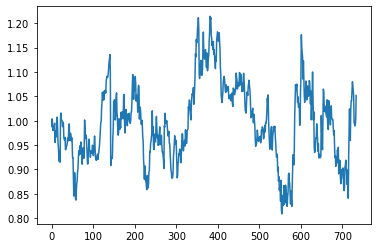

In [6]:
kf_beta = pd.Series(lst)
kf_beta.plot()

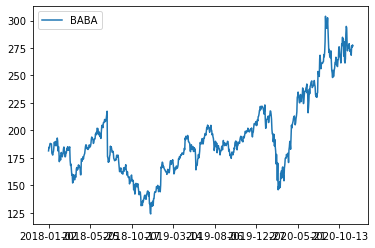

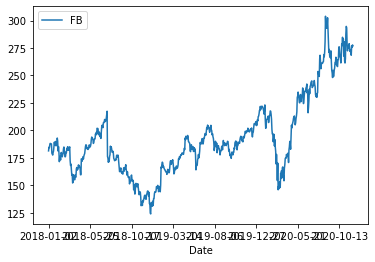

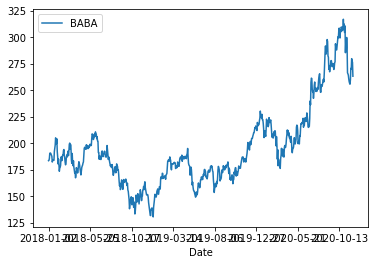

In [36]:
ls = []
for i in range(len(BABA)):
    ls.append(BABA.iloc[i]*kf_beta[i])
a = pd.DataFrame(ls)
a.plot()
FB.plot()


In [32]:
kf_beta.iloc[0]

0.9878536472530631

In [7]:
from utility import LinearRegression as LR
BABA = pd.DataFrame(coint_prices.BABA)
FB = pd.DataFrame(coint_prices.FB)

model = LR(x = BABA, y = FB)
residuals = pd.DataFrame(model.error.reshape(1,len(FB))[0],
                         index = BABA.index,
                         columns = ['Residual(FB - β·BABA)'])
residuals.head()

importing Jupyter notebook from utility.ipynb


,Residual(FB - β·BABA)
Date,
2018-01-02,-2.053493
2018-01-03,0.893997
2018-01-04,-0.923957
2018-01-05,-2.716797
2018-01-08,-0.967018


In [8]:
from utility import VAR

model = VAR(residuals, lag = 1)
B = model.coef.values[0][0]
C = model.coef.values[1][0]
mu = C/(1-B)
tau = 1/252
SSE = np.sum(model.error**2)
sigma_eq = ((SSE*tau/(1-B**2))**0.5).values[0]
Z = 1
upper_bound = mu +  Z * sigma_eq
lower_bound = mu -  Z * sigma_eq

====================Cumulative Profit====================
0     30.078133
1     73.563542
2    100.886098
3    134.927843
4    165.238010
5    213.101530
6    244.252524
7    276.769777
dtype: float64


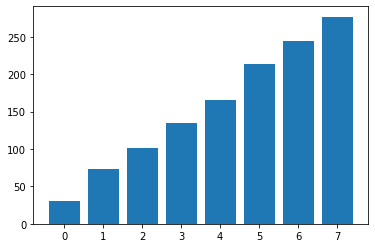

In [9]:
from utility import Backtest2
df = pd.read_csv(datafile, index_col = 'Date')
df['res_past'] = residuals.shift().fillna(0)
df['res'] = residuals
test = Backtest2(df,upper_bound, lower_bound, mu)
trading_rec = test.Signal_generation(daily=False)
test.PL(trading_rec, beta = kf_beta)

In [10]:
trading_rec

,BABA,FB,res_past,res,action
Date,,,,,
2018-03-20,198.949997,168.149994,-20.317073,-28.547278,entry2
2018-06-21,202.210007,201.500000,-0.989369,1.985104,exit
2018-07-24,189.000000,214.669998,24.506539,26.572501,entry1
2018-07-26,194.179993,176.259995,21.641100,-16.314566,exit
2018-11-27,156.460007,135.000000,-23.204257,-24.973207,entry2
2019-04-25,187.880005,193.259995,-2.639378,6.130508,exit
2019-05-30,151.070007,183.009995,25.656716,27.695360,entry1
2019-12-11,204.639999,202.259995,2.876275,0.644858,exit
2020-03-09,197.660004,169.500000,-20.525140,-26.082332,entry2


0.9878536472530631
1.0036390257232717
0.9925670535678348
0.9798094306620091
0.9892271764951387
0.9846416534117488
0.9897234828133306
0.9948059181028068
0.9551610635019147
0.978013065893937
0.9661080595865315
0.9750521383917009
0.9850018439561872
1.0073337774786708
0.9847601017762484
0.95407199969126
0.9452915019242196
0.9258342332772684
0.9161109779996666
0.9371913418524473
0.9148255648381274
1.0045233818218926
1.015853896505756
1.0040415118775865
1.0007539848741638
0.9993321843006275
0.987792829766009
0.9968278794380468
0.9941929784541652
0.9659673709499819
0.9612317748972544
0.9600407720434816
0.9655902683106611
0.9402728217348053
0.9422181681576098
0.9482894542930882
0.948262437103325
0.9523128443989162
0.9638777524792852
0.957986711448501
0.9667542215672268
0.9825299382667748
0.9933897398445632
0.9594902432095199
0.9717514677406348
0.9741405336432651
0.972078869449183
0.9585952645834035
0.9653395368530597
0.9565312645129157
0.923639688397432
0.9241545061673966
0.8870597092421795
0.

1.0644587638891174
1.0490397648344043
1.0219294634396652
1.0058741909264919
1.0081981654589278
1.0172666345477344
1.0201109928055085
1.0256509325887173
0.9967984165527236
0.9958375842528477
1.0130804003453422
1.002093559576226
0.9883681913683008
0.9621012139717501
0.9472923971562328
0.9562721739459289
0.9529718577455895
0.9642840660687357
0.9806292978640313
0.9719655363714598
0.9597341417033562
0.9573400629570037
0.9602997741013508
0.9657941934254985
0.960075539955776
0.9677022877840108
0.9545420176756266
0.961611381228418
0.9813499552799713
0.9789995496931079
0.9872461663446619
0.9843073699976655
0.9742201464230019
0.9628155208743282
0.967193603305767
0.9826253540913911
0.990308446794212
0.9767388405668354
0.9963090965817791
0.9952767516554555
1.0028734089791458
1.0196006384058012
1.0457467793157085
1.0359589798004762
1.052870534441264
1.004553250032099
0.9773450048432997
0.958187230136721
0.9414470330976324
0.9540898691124668
0.9545029437787361
0.9806014974741871
0.9874387297431673
0

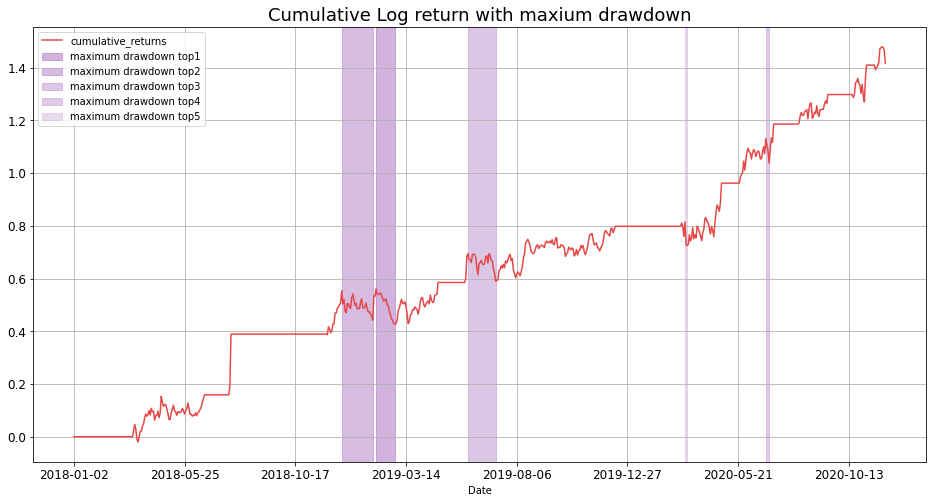

In [11]:
trading_d_rec = test.Signal_generation()
trading_d_rec = test.Returns(trading_d_rec, beta = kf_beta)
test.plot(trading_d_rec)
